In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pygltflib
import base64

In [2]:
image = cv2.imread('cat_classical_mask.jpg', cv2.IMREAD_GRAYSCALE)
height, width = image.shape
downscale_factor = 80/height if height >= width else 80/width
image = cv2.resize(image, ((int)(width/(1/downscale_factor)),(int)(height/(1/downscale_factor))), cv2.INTER_NEAREST)
_, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    
binary = binary/255
print(binary.shape)

(77, 80)


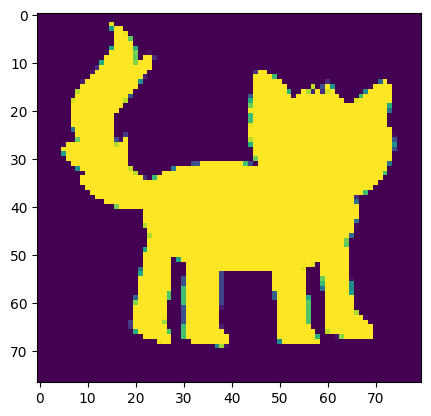

In [3]:
plt.imshow(image)

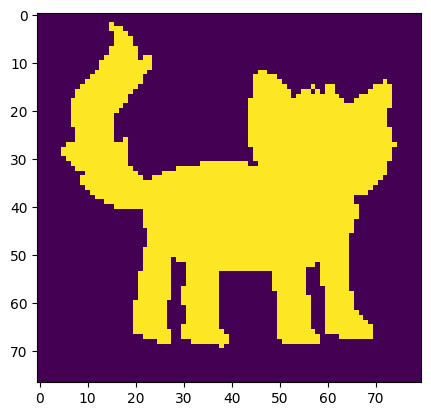

In [4]:
plt.imshow(binary)

In [5]:
def interpolate(v1, v2, val1, val2):
    if val1 != val2:
        return v1 + (v2 - v1) * (0.5 - val1) / (val2 - val1)
    else:
        return (v1 + v2) / 2

In [6]:
def marching_squares(image):
    rows, cols = image.shape
    vertices = []
    faces = []

    lookup_table = {
        1:  [(0,0), (0.5,0), (0,0.5), (0,0.5), (0.5,0), (0.5,0.5)],  # Bottom-left triangle
        2:  [(0.5,0), (1,0), (0.5,0.5), (0.5,0.5), (1,0), (1,0.5)],  # Bottom-right triangle
        4:  [(0.5,0.5), (1,0.5), (0.5,1), (0.5,1), (1,0.5), (1,1)],  # Top-right triangle
        8:  [(0,0.5), (0.5,0.5), (0,1), (0,1), (0.5,0.5), (0.5,1)],  # Top-left triangle
        3:  [(0,0), (1,0), (0,1), (1,0), (1,1), (0,1)],              # Vertical edge
        6:  [(0,0), (1,1), (1,0), (0,0), (0,1), (1,1)],              # Horizontal edge
        9:  [(0,0), (1,0), (1,1), (0,0), (1,1), (0,1)],              # Diagonal edge
        12: [(1,1), (0,0), (1,0), (0,1), (0,0), (1,1)],              # Diagonal edge
        5:  [(0,0), (0.5,0), (0.5,1), (0,0), (0.5,1), (0,1)],        # Left vertical split
        10: [(0.5,0), (1,0), (1,1), (0.5,0), (1,1), (0.5,1)],        # Right vertical split
        7:  [(0,0), (1,0), (0,1), (1,0), (1,1), (0,1)],              # Complex top-left, bottom-right
        14: [(0,0), (1,0), (1,1), (0,0), (1,1), (0,1)],              # Complex top-right, bottom-left
        13: [(1,0), (0,1), (1,1), (0,0), (0,1), (1,0)],              # Complex bottom-right, top-left
        11: [(1,0), (1,1), (0,1), (0,0), (0,1), (1,0)],              # Complex bottom-left, top-right
        15: [(0,0), (1,0), (1,1), (0,0), (1,1), (0,1)],              # Full square
    }
    for y in range(rows - 1):
        for x in range(cols - 1):
            square = image[y:y+2, x:x+2]
            index = square[0,0] * 1 + square[0,1]* 2 + square[1,1] * 4 + square[1,0] * 8
            if index > 0:
                base_vertices = lookup_table.get(index, [])
                face_vertices = []
                for vert in base_vertices:
                    v = (x + vert[0], y + vert[1])
                    if v not in vertices:
                        vertices.append(v)
                    face_vertices.append(vertices.index(v))
                for i in range(0, len(face_vertices), 3):
                    faces.append(face_vertices[i:i+3])
    return np.array(vertices), np.array(faces)


In [7]:
def normalize_vertices(vertices):
    min_x, min_y = np.min(vertices, axis=0)
    max_x, max_y = np.max(vertices, axis=0)
    
    width = max_x - min_x
    height = max_y - min_y
    
    scale_factor = 1.0 / max(width, height)
    
    vertices_normalized = (vertices - np.array([min_x, min_y])) * scale_factor
    
    return vertices_normalized
    

In [8]:
def center_vertices(vertices):
    center_x, center_y = np.mean(vertices, axis=0)

    vertices_centered = vertices - np.array([center_x, center_y])
    
    return vertices_centered

In [9]:
def flip_vertically(vertices):
    vertices_flipped = vertices * np.array([1,-1])
    return vertices_flipped

In [10]:
def export_gltf(vertices, faces):
    points = np.zeros((vertices.shape[0], 3),dtype=np.float32)
    points[:,:2] = vertices.astype(np.float32)

    triangles = faces.astype(np.uint32)
    
    triangles_binary_blob = triangles.flatten().tobytes()
    points_binary_blob = points.tobytes()

    gltf = pygltflib.GLTF2(
        scene=0,
        scenes=[pygltflib.Scene(nodes=[0])],
        nodes=[pygltflib.Node(
            mesh=0,
            name="Subject"
        )],
        meshes=[
            pygltflib.Mesh(
                primitives=[
                    pygltflib.Primitive(
                        attributes=pygltflib.Attributes(POSITION=1), indices=0
                    )
                ]
            )
        ],
        accessors=[
            pygltflib.Accessor(
                bufferView=0,
                componentType=pygltflib.UNSIGNED_INT,
                count=triangles.size,
                type=pygltflib.SCALAR,
                max=[int(triangles.max())],
                min=[int(triangles.min())],
            ),
            pygltflib.Accessor(
                bufferView=1,
                componentType=pygltflib.FLOAT,
                count=len(points),
                type=pygltflib.VEC3,
                max=points.max(axis=0).tolist(),
                min=points.min(axis=0).tolist(),
            ),
        ],
        bufferViews=[
            pygltflib.BufferView(
                buffer=0,
                byteLength=len(triangles_binary_blob),
                target=pygltflib.ELEMENT_ARRAY_BUFFER,
            ),
            pygltflib.BufferView(
                buffer=0,
                byteOffset=len(triangles_binary_blob),
                byteLength=len(points_binary_blob),
                target=pygltflib.ARRAY_BUFFER,
            ),
        ],
        buffers=[
            pygltflib.Buffer(
                byteLength=len(triangles_binary_blob) + len(points_binary_blob)
            )
        ],
    )
    binary_blob = triangles_binary_blob + points_binary_blob
    base64_blob = base64.b64encode(binary_blob).decode('utf-8')
    gltf.buffers[0].uri = f"data:application/octet_stream;base64,{base64_blob}"
    
    gltf.save("export.gltf")

In [11]:
def plot_mesh(vertices, faces):
    plt.figure(figsize=(8, 8))
    for face in faces:
        face_vertices = vertices[face]
        plt.fill(face_vertices[:, 0], face_vertices[:, 1], edgecolor='black', fill=False)
    plt.scatter(vertices[:, 0], vertices[:, 1], color='red')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

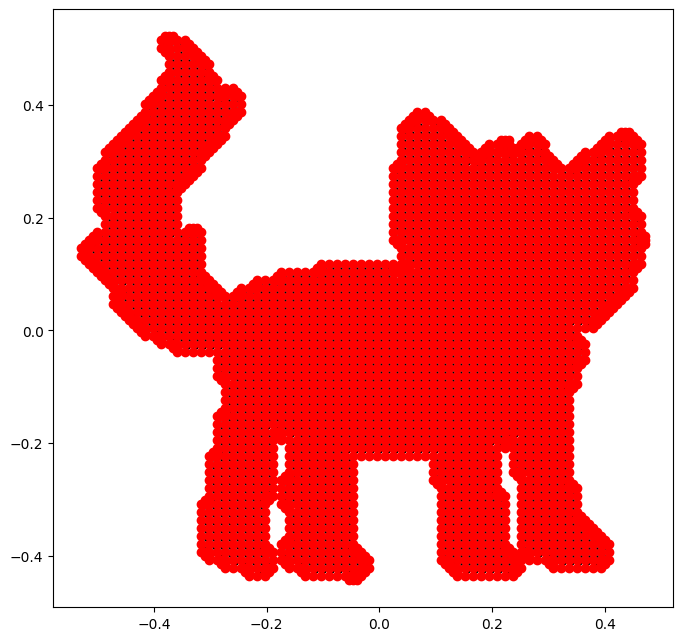

In [12]:
vertices, faces = marching_squares(binary)
vertices = normalize_vertices(vertices)
vertices = center_vertices(vertices)
vertices = flip_vertically(vertices)
plot_mesh(vertices,faces)
export_gltf(vertices,faces)